# IMAGE CAPTION GENERATOR

This notebook aims to generate realistic captions based on input images, using CNN as Image Model and RNN / LSTM as Language Model.

## A Brief Approach to the Problem Statement

The approach utilised here is that of an Encoder-Decoder Model, i.e, the Encoder model will combine both the encoded form of the image and the encoded form of the caption (text) and feed it to the Decoder model. We will train the part of the neural network that handles images and the part that handles languages separately, using images and sentences from separate training sets. This is because the merging of image features with text encodings to a later stage in the architecture is advantageous and can generate better quality captions with smaller layers than the inject architecture.

## Logic for Implementation

- To encode our image features we will make use of **Transfer Learning** by using the inceptionV3 model.


- To encode our text sequence we will map every word to a 200-dimensional vector, using a pre-trained **Glove Model** post the processing of embedding layer.


- To generate the caption we will be using two methods
    - Greedy Search
    - Beam Search
    
    
- The dataset we'll be using is the **Flickr8k dataset** in which each image is associated with five different captions that describe the entities and events depicted in the image that were collected.


- The primary python module / library we'll be using for this problem statement is the **keras** module.

## Building the Image Caption Generator

### STEP 1 :- Importing the libraries / modules

We import all the required modules in this step, as follows :

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers.merge import add
from tensorflow.keras.utils import to_categorical, plot_model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import load_model
from PIL import Image
import requests
import matplotlib.pyplot as plt
import cv2
import string
import glob
import pickle

### STEP 2 :- Data Preprocessing

For each image ID, there are multiple descriptions, so we create a function that returns a list of all descriptions for a given image ID :

In [2]:
def load_description(text):
    mapping = dict()
    for line in text.split("\n"):
        token = line.split("\t")
        if len(line) < 2:
            continue
        img_id = token[0].split('.')[0]
        img_des = token[1]
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping

token_path = 'D:/Image Caption Generator/Flickr8k_text/Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read()
descriptions = load_description(text)
print(descriptions['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


### STEP 3 :- Cleaning the Text

The function "load_description" returns a dictionary of image IDs and a list of their corresponding descriptions. However, those descriptions need to be preprocessed and cleaned, like lowercasing the text and removing punctuation marks. The following function achieves this cleaning of text :

In [3]:
def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption = [c for c in caption if c not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption
            
clean_description(descriptions)
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

### STEP 4 :- Generating the Vocabulary

Generating a vocabulary is a necessary step in NLP problems, like this one. Basically, keeping a set or a list of unique words in our entire textual data, is known as vocabulary. We simply need to add every description into Python's in-built "set()" function and it will generate the desired vocabulary for us :

In [4]:
def to_vocab(desc):
    words = set()
    for key in desc.keys():
        for line in desc[key]:
            words.update(line.split())
    return words

vocab = to_vocab(descriptions)
vocab

{'lighterskinned',
 'presidential',
 'izod',
 'contest',
 'hairdo',
 'waterfall',
 'alleyway',
 'warm',
 'trek',
 'perforced',
 'casts',
 'soccer',
 'heron',
 'sprinkled',
 'bursting',
 'fiddle',
 'sit',
 'ashy',
 'bras',
 'gift',
 'tips',
 'seesaw',
 'upper',
 'tentlike',
 'brush',
 'range',
 'change',
 'naturally',
 'stirring',
 'odd',
 'trains',
 'formally',
 'oars',
 'views',
 'mail',
 'ones',
 'developed',
 'neptuno',
 'freesbies',
 'kicked',
 'weeping',
 'banging',
 'office',
 'equpiment',
 'mountain',
 'buy',
 'waterskiis',
 'blondhair',
 'underhang',
 'skipping',
 'hook',
 'hoses',
 'glacier',
 'fishemen',
 'ditch',
 'hankerchief',
 'confront',
 'powerwashing',
 'fetched',
 'kidsized',
 'paddles',
 'band',
 'scaling',
 'farward',
 'jet',
 'bulletproof',
 'armbands',
 'bonfire',
 'gigolo',
 'dunks',
 'canopy',
 'longhaired',
 'fangs',
 'clapped',
 'lightcolored',
 'lifevest',
 'balance',
 'skaters',
 'mortar',
 'guitarists',
 'orangesunset',
 'weirmeiner',
 'phones',
 'eight',
 

### STEP 5 :- Loading the images

In this step, we load all those images from the local directory, on which we want to train our deep learning model. For training purposes, we will also preprocess the descriptions of these images so they have "startseq" and "endseq" at the beginning and the at the end of each line respectively. This helps the model understand and recognize when the description has begun and when it has ended :

In [5]:
images = "D:/Image Caption Generator/Flickr8k_Dataset/"

# Create a list of all images in the directory
img = glob.glob(images + '*.jpg')

train_path = 'D:/Image Caption Generator/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding='utf-8').read().split("\n")
train_img = []  # list of all images in a training set
for i in img:
    if(i[len(images):] in train_images):
        train_img.append(i)
        
# Load descriptions of training set in a dictionary. Name of the image will act as key.
def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    for key, des_list in des.items():
        if key+'.jpg' in dataset:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc)
    return dataset_des

train_descriptions = load_clean_descriptions(descriptions, train_images)
print(train_descriptions['1000268201_693b08cb0e'])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


### STEP 6 :- Feature Vector Extraction

This step encodes the images into vectors using the InceptionV3 pre-trained architecture. The process of extracting vectors from words based on certain parameters is known as **feature vector extraction** :

In [6]:
def preprocess_img(img_path):
    # inceptionV3 excepts images in 299*299*3
    img = load_img(img_path, target_size=(299,299))
    x = img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def encode(image):
    image = preprocess_img(image)
    vec = model.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec

base_model = InceptionV3(weights='imagenet')
model = Model(base_model.input, base_model.layers[-2].output)

# Run the encode function on all train images and store the feature vectors in a list
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)

### STEP 7 :- Tokenizing the vocabulary

In [7]:
# List of all training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for caption in val:
        all_train_captions.append(caption)
        
# Consider only those words which occur atleast 10 times
vocabulary = vocab
threshold = 10
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1
        
vocab = [word for word in word_counts if word_counts[word] >= threshold]

# Word mapping to integers
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1
    
# Find the max length of a description in a dataset
max_length = max(len(des.split()) for des in all_train_captions)
max_length

34

### STEP 8 :- Glove vector embeddings

In [8]:
x1 = []
x2 = []
y = []
for key, des_list in train_descriptions.items():
    pic = encoding_train[key+'.jpg']
    for cap in des_list:
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=1652)[0]
            # Store
            x1.append(pic)
            x2.append(in_seq)
            y.append(out_seq)
            
x2 = np.array(x2)
x1 = np.array(x1)
y = np.array(y)

# Load the glove vectors for embedding layer
embeddings_index = {}
glove_path = 'D:/Image Caption Generator/glove6b/glove.6B.200d.txt'
glove = open(glove_path, 'r', encoding='utf-8').read()
for line in glove.split("\n"):
    values = line.split(" ")
    word = values[0]
    indices = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = indices
    
emb_dim = 200
emb_matrix = np.zeros((1652, emb_dim))
for word, i in wordtoix.items():
    emb_vec = embeddings_index.get(word)
    if emb_vec is not None:
        emb_matrix[i] = emb_vec
emb_matrix.shape

(1652, 200)

### STEP 9 :- Defining the model

In [ ]:
ip1 = Input(shape=(2048, ))
fe1 = Dropout(0.2)(ip1)
fe2 = Dense(256, activation='relu')(fe1)
ip2 = Input(shape=(max_length, ))
se1 = Embedding(1652, emb_dim, mask_zero=True)(ip2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(1652, activation='softmax')(decoder2)
model = Model(inputs=[ip1,ip2], outputs=outputs)

### STEP 10 :- Training the model

In [ ]:
model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit([x1,x2], y, epochs=100, batch_size=128)

In [ ]:
model.save("image-caption-generator.h5")

In [9]:
loaded_model = load_model("image-caption-generator.h5")

### STEP 11 :- Predicting the output

As the model generates a long vector with a probability distribution across all the words in the vocabulary we greedily pick the word with the highest probability to get the next word prediction. This is known as **Greedy Search**.

In [10]:
def greedy_search(pic):
    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = loaded_model.predict([pic, seq])
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

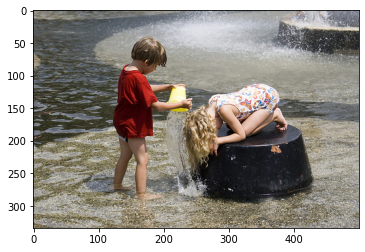

'two girls playing in fountain'

In [11]:
base_model = InceptionV3(weights='imagenet')
imodel = Model(base_model.input, base_model.layers[-2].output)

def encode2(image):
    image = preprocess_img(image)
    vec = imodel.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec

# bic = 'D:/ICG-GPT/train2014/COCO_train2014_000000000510.jpg'
bic = train_img[841]
encd = encode2(bic)
encd = encd.reshape((1,2048))
y = plt.imread(bic)
plt.imshow(y)
plt.show()

greedy_search(encd)

Pickling variables into a file :

In [ ]:
with open('variables.pkl', 'wb') as f:
    pickle.dump((max_length, wordtoix, ixtoword, train_img), f)

**Beam Search** is where we take top K predictions, feed them again in the model and then sort them using the probabilities returned by the model. That way the list will always contain the top K predictions and we take the one with the highest probability and go through it till we encounter 'endseq' or reach maximum caption length.

In [12]:
def beam_search(pic, beam_index=3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = loaded_model.predict([pic, par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda x: x[1])
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i!='endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

We now define a function for generating captions using both, Greedy and Beam approaches :

In [13]:
def caption_for(img):
    encd = encode2(img).reshape((1,2048))
    y = plt.imread(img)
    plt.imshow(y)
    plt.show()
    c1 = greedy_search(encd)
    c2 = beam_search(encd)
    print(f"Greedy Search : {c1}\nBeam Search : {c2}")

**TRYING OUT THE OUTPUTS FOR DIFFERENT IMAGES**

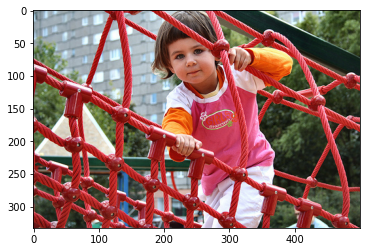

Greedy Search : boy in red shirt is climbing tree
Beam Search : young boy in red shirt is climbing chain link fence


In [14]:
caption_for(train_img[5])

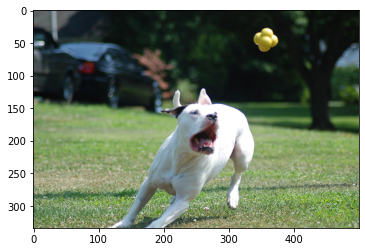

Greedy Search : white dog is running through field of yellow flowers
Beam Search : white dog is about to catch yellow ball in its mouth


In [15]:
caption_for(train_img[14])

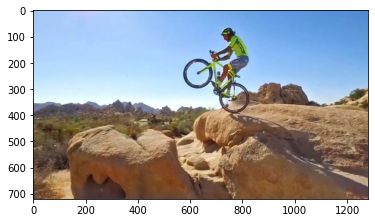

Greedy Search : man is riding his bmx bike through the air above the ground
Beam Search : man on bmx bike is jumping through the air near water


In [16]:
caption_for("custom_images/bikestunt.jpg")

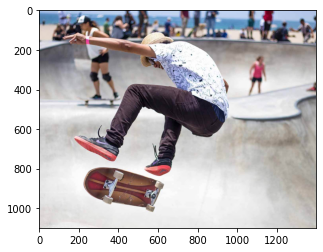

Greedy Search : man in red shirt and black pants skateboarding on skateboard
Beam Search : the skateboarder does trick near construction


In [17]:
caption_for("custom_images/sktbrd.jpg")